# Recommender Systems Analysis and Visualization
This notebook performs an exploratory analysis of recommender systems using the Sim4Rec library.
We'll generate synthetic data, compare multiple baseline recommenders, and visualize their performance.


## Cell: Import libraries and set up environment

In [23]:
import os
import sys
os.environ['SPARK_HOME'] = "C:/spark"
os.environ['HADOOP_HOME'] = r"C:/spark"
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'lab'
os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['JAVA_HOME'] = r"C:/Program Files/Eclipse Adoptium/jdk-17.0.11"
os.environ['PYSPARK_PYTHON'] = sys.executable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import shutil

from pyspark.sql import SparkSession
from pyspark.sql import functions as sf
from pyspark.sql import DataFrame, Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import DoubleType, ArrayType

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)


## Yikes

In [ ]:
import os
import sys
import subprocess

# Since we know Java 11 is in the system PATH, we can use it directly
# Java 11 is perfectly fine for Spark 3.5.x

# Clear any incorrect JAVA_HOME
if 'JAVA_HOME' in os.environ:
    del os.environ['JAVA_HOME']

# Set up Spark environment
os.environ['SPARK_HOME'] = "C:/spark/spark-3.5.6-bin-hadoop3"
os.environ['HADOOP_HOME'] = os.environ['SPARK_HOME']
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Add Spark to PATH
spark_bin = os.path.join(os.environ['SPARK_HOME'], 'bin')
if spark_bin not in os.environ['PATH']:
    os.environ['PATH'] = f"{spark_bin};{os.environ['PATH']}"

print("Environment set up complete")
print(f"SPARK_HOME: {os.environ['SPARK_HOME']}")
print(f"Using system Java 11")

# spark = SparkSession.builder \
#     .appName("RecSysVisualization") \
#     .master("local[*]") \
#    .config("spark.driver.maxResultSize", "0") \
    # .config("spark.driver.memory", "20g") \
    # .config("spark.executor.memory", "20g") \
    # .config("spark.driver.memoryOverhead", "4g") \
    # .config("spark.executor.memoryOverhead", "4g") \
    # .config("spark.sql.shuffle.partitions", "200") \
    # .config("spark.sql.adaptive.enabled", "true") \
    # .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    # .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    # .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    # .config("spark.sql.execution.arrow.maxRecordsPerBatch", "10000") \
    # .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    # .config("spark.kryoserializer.buffer.max", "1g") \
    # .config("spark.sql.autoBroadcastJoinThreshold", "100MB") \
    # .config("spark.sql.broadcastTimeout", "36000") \
    # .config("spark.network.timeout", "800s") \
    # .config("spark.executor.heartbeatInterval", "60s") \
    # .config("spark.storage.memoryFraction", "0.6") \
    # .config("spark.storage.unrollFraction", "0.2") \
    # .config("spark.rdd.compress", "true") \
    # .config("spark.shuffle.compress", "true") \
    # .config("spark.shuffle.spill.compress", "true") \
    # .config("spark.checkpoint.compress", "true") \
    # .config("spark.io.compression.codec", "lz4") \
    # .config("spark.sql.files.maxPartitionBytes", "134217728") \
    # .config("spark.sql.files.openCostInBytes", "4194304") \
    # .config("spark.default.parallelism", "200") \
    # .config("spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled", "false") \
    # .config("spark.python.worker.memory", "8g") \
    # .config("spark.python.worker.reuse", "true") \
    # .config("spark.executor.cores", "8") \
    # .config("spark.task.cpus", "1") \
    # .config("spark.dynamicAllocation.enabled", "true") \
    # .config("spark.speculation", "false") \
    # .getOrCreate()

# spark.sparkContext.setLogLevel("WARN")



# Add the necessary environment variables

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["spark_python"] = os.getenv('SPARK_HOME') + "\\python"
os.environ["py4j"] = os.getenv('SPARK_HOME') + "\\python\lib\py4j-0.10.9.7-src.zip"

# Retrieve the values from the environment variables
spark_python_path = os.environ["spark_python"]
py4j_zip_path = os.environ["py4j"]

# Add the paths to sys.path
for path in [spark_python_path, py4j_zip_path]:
    if path not in sys.path:
        sys.path.append(path)

# Verify that the paths have been added to sys.path
print("sys.path:", sys.path)


print("Spark session initialized successfully!")

Environment set up complete
SPARK_HOME: C:/spark/spark-3.5.6-bin-hadoop3
Using system Java 11
sys.path: ['c:\\Users\\jackn\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\jackn\\AppData\\Local\\Temp\\spark-1af93122-c317-4ed0-b783-153c7cf42c9d\\userFiles-951d174a-a964-4bb5-b4d7-ed37079d7ae0', 'c:\\Users\\jackn\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'c:\\Users\\jackn\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'c:\\Users\\jackn\\AppData\\Local\\Programs\\Python\\Python312', '', 'C:\\Users\\jackn\\AppData\\Roaming\\Python\\Python312\\site-packages', 'C:\\Users\\jackn\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32', 'C:\\Users\\jackn\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\jackn\\AppData\\Roaming\\Python\\Python312\\site-packages\\Pythonwin', 'c:\\Users\\jackn\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages', 'c:\\Users\\jackn\\AppData\\Local\\Programs\\Python\\Python312\\Lib\

<>:77: SyntaxWarning: invalid escape sequence '\l'
<>:77: SyntaxWarning: invalid escape sequence '\l'
C:\Users\jackn\AppData\Local\Temp\ipykernel_30496\2152686485.py:77: SyntaxWarning: invalid escape sequence '\l'
  os.environ["py4j"] = os.getenv('SPARK_HOME') + "\\python\lib\py4j-0.10.9.7-src.zip"


## Initialize Spark session

In [25]:
spark = SparkSession.builder \
    .appName("RecSysVisualization") \
    .master("local[*]") \
    .config("spark.driver.memory", "14g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("Spark session initialized.")

Spark session initialized.


## Import competition modules 

In [26]:
import sys
print("Python executable:", sys.executable)
print("Python version:", sys.version)

try:
    import sdv
    print("SDV version:", sdv.__version__)
    print("SDV location:", sdv.__file__)
except ImportError:
    print("SDV is not installed in this environment")

Python executable: c:\Users\jackn\AppData\Local\Programs\Python\Python312\python.exe
Python version: 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
SDV version: 1.22.1
SDV location: c:\Users\jackn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\__init__.py


In [27]:
from data_generator import CompetitionDataGenerator
from simulator import CompetitionSimulator
from sample_recommenders import (
    RandomRecommender,
    PopularityRecommender#,
    #ContentBasedRecommender
)
from config import DEFAULT_CONFIG, EVALUATION_METRICS

print("Competition modules imported.")

Competition modules imported.


## Define custom recommender template
Below is a template class for implementing a custom recommender system. You should extend this class with your own recommendation algorithm.

In [40]:
# from typing import Literal, Optional, Union
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import random
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from pyspark.sql import functions as sf
from pyspark.sql.types import IntegerType, StructType, StructField

class kNearestRecommender:
    """
    k Nearest Neighbors recommender system.
    Recommends items based on kNN classifier.
    """
    
    def __init__(self, metric='euclidean', k_range=range(3, 25), seed=None):
        """
        Initialize recommender.
        
        Args:
            seed: Random seed for reproducibility
            metric: Chosen distance metric for determining neighbors {"euclidean", "manhattan", "cosine", "minkowski"}
            k_range: Range of k values to test
        """
        self.seed = seed
        self.metric = metric
        self.k_range = k_range
        self.feature_cols = None
        self.categorical_cols = []
        self.numerical_cols = []
        self.best_k = None
        self.best_metric = None
        self.preprocess = None
        self.model = None
        self.spark = None

        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

    def process_cols(self, data):
        self.feature_cols = data.columns.tolist()

        nonfeature_cols = ["user_idx", "relevance"]

        self.feature_cols = [col for col in data.columns if col not in nonfeature_cols]

        for col in data[self.feature_cols].columns:
            if data[col].dtype in ['object', 'bool', 'category']:
                self.categorical_cols.append(col)
            else:
                self.numerical_cols.append(col) 

        return data
    
    def create_pipeline(self):
        transformers = []

        if self.numerical_cols:
            numerical_transformer = Pipeline(
                steps=[
                    ('scaler', StandardScaler())
                ]
            )
            transformers.append(('num', numerical_transformer, self.numerical_cols))
        
        if self.categorical_cols:
            categorical_transformer = Pipeline(
                steps=[
                    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
                ]
            )
            transformers.append(('cat', categorical_transformer, self.categorical_cols))
        
        if transformers:
            self.preprocess = ColumnTransformer(transformers=transformers)
        else:
            self.preprocess = None

    def select_k(self, X, y):
        knn = KNeighborsRegressor(metric=self.metric, weights="distance")
        pipe = Pipeline([("prep", self.preprocess), ("knn", knn)])
        param_grid = {"knn__n_neighbors": list(self.k_range)}
        gs = GridSearchCV(pipe,
                        param_grid=param_grid,
                        scoring="neg_root_mean_squared_error",
                        cv=3,
                        n_jobs=-1)
        gs.fit(X, y)

        self.best_k = gs.best_params_["knn__n_neighbors"]
        self.model = gs.best_estimator_
        self.train_x = X
        self.train_y = y
    
    def fit(self, log, user_features=None, item_features=None):
        """
        Train the recommender model based on interaction history.
        """
        self.spark = log.sparkSession
        
        # Convert to pandas
        log_pd = log.toPandas()
        if user_features is not None:
            user_pd = user_features.toPandas()
        else:
            user_pd = pd.DataFrame(columns=["user_idx"])
        if item_features is not None:
            item_pd = item_features.toPandas()
        else:
            item_pd = pd.DataFrame(columns=["item_idx"])
        
        # Merge data
        data = log_pd.merge(user_pd, on='user_idx', how='left').merge(item_pd, on='item_idx', how='left')

        data = self.process_cols(data)

        self.create_pipeline()
        X = data[self.feature_cols]
        y = data['relevance'].astype(np.int32)

        # Select best k
        self.select_k(X, y)

        # Fit and transform the preprocessing pipeline
        if self.preprocess:
            X_transformed = self.preprocess.fit_transform(X)
        else:
            X_transformed = X.values

        # Fit the model with transformed data
        self.model = NearestNeighbors(n_neighbors=self.best_k,
                                    metric=self.metric,
                                    n_jobs=-1)
        
        self.model.fit(X_transformed)
        self.train_x = X_transformed
        self.train_y = y
    
    def predict(self, log, k, users, items, user_features=None, item_features=None, filter_seen_items=True):
        """
        Generate recommendations for users.
        
        Args:
            log: Interaction log with user_idx, item_idx, and relevance columns
            k: Number of items to recommend
            users: User dataframe
            items: Item dataframe
            user_features: User features dataframe (optional)
            item_features: Item features dataframe (optional)
            filter_seen_items: Whether to filter already seen items
        
        Returns:
            DataFrame: Recommendations with user_idx, item_idx, and relevance columns
        """
        users_pd = users.toPandas()
        items_pd = items.toPandas()
        
        if user_features is not None:
            user_feat_pd = user_features.toPandas()
        else:
            user_feat_pd = pd.DataFrame({'user_idx': users_pd['user_idx']})
            
        if item_features is not None:
            item_feat_pd = item_features.toPandas()
        else:
            item_feat_pd = pd.DataFrame({'item_idx': items_pd['item_idx']})
        
        # Create all user-item pairs
        user_item_pairs = pd.DataFrame(
            [(user, item) for user in users_pd['user_idx'] for item in items_pd['item_idx']],
            columns=['user_idx', 'item_idx']
        )
        
        X_test_data = user_item_pairs.merge(user_feat_pd, on='user_idx', how='left').merge(item_feat_pd, on='item_idx', how='left')
        
        for col in self.feature_cols:
            if col not in X_test_data.columns:
                if col in self.categorical_cols:
                    X_test_data[col] = 'unknown'
                else:
                    X_test_data[col] = 0

        # Add missing columns with default values to match training features
        for col in self.feature_cols:
            if col not in X_test_data.columns:
                X_test_data[col] = 0
        
        for col in self.numerical_cols:
            if col in X_test_data.columns:
                X_test_data[col] = pd.to_numeric(X_test_data[col], errors='coerce').fillna(0)
        
        # Ensure we only use the same features as training
        X_test_features = X_test_data[self.feature_cols]
        
        # Transform the test data
        if self.preprocess:
            X_test = self.preprocess.transform(X_test_features)
        else:
            X_test = X_test_features.values
        
        # Get nearest neighbors
        distances, indices = self.model.kneighbors(X_test)
        
        # Calculate weighted relevance
        train_y_array = self.train_y.values if hasattr(self.train_y, 'values') else self.train_y
        
        weights = 1 / (distances + 1e-10)
        neighbor_relevances = train_y_array[indices]
        weighted_relevance = np.sum(weights * neighbor_relevances, axis=1) / np.sum(weights, axis=1)
        
        # Create recommendations dataframe
        recommendations = X_test_data[['user_idx', 'item_idx']].copy()
        recommendations['relevance'] = np.round(weighted_relevance).astype(np.int32)
        
        # Filter seen items if requested
        if filter_seen_items and log is not None:
            log_pd = log.toPandas() if hasattr(log, 'toPandas') else log
            seen_items = set(zip(log_pd['user_idx'], log_pd['item_idx']))
            recommendations = recommendations[~recommendations.apply(lambda x: (x['user_idx'], x['item_idx']) in seen_items, axis=1)]
        
        # Get top k recommendations per user
        recommendations = (recommendations
                        .sort_values(['user_idx', 'relevance'], ascending=[True, False])
                        .groupby('user_idx')
                        .head(k)
                        .reset_index(drop=True))
        
        # Ensure correct data types
        recommendations['user_idx'] = recommendations['user_idx'].astype(int)
        recommendations['item_idx'] = recommendations['item_idx'].astype(int)
        recommendations['relevance'] = recommendations['relevance'].astype(int)
        
        # Convert back to Spark DataFrame
        schema = StructType([
            StructField("user_idx", IntegerType(), True),
            StructField("item_idx", IntegerType(), True),
            StructField("relevance", IntegerType(), True)
        ])
        
        spark_df = self.spark.createDataFrame(recommendations, schema)
        
        return spark_df


print("kNearestRecommender template defined.")

kNearestRecommender template defined.


In [29]:
class MyRecommender:
    """
    Template class for implementing a custom recommender.
    
    This class provides the basic structure required to implement a recommender
    that can be used with the Sim4Rec simulator. Students should extend this class
    with their own recommendation algorithm.
    """
    
    def __init__(self, seed=None):
        """
        Initialize recommender.
        
        Args:
            seed: Random seed for reproducibility
        """
        self.seed = seed
        # Add your initialization logic here
    
    def fit(self, log, user_features=None, item_features=None):
        """
        Train the recommender model based on interaction history.
        
        Args:
            log: Interaction log with user_idx, item_idx, and relevance columns
            user_features: User features dataframe (optional)
            item_features: Item features dataframe (optional)
        """
        # Implement your training logic here
        # For example:
        #  1. Extract relevant features from user_features and item_features
        #  2. Learn user preferences from the log
        #  3. Build item similarity matrices or latent factor models
        #  4. Store learned parameters for later prediction
        pass
    
    def predict(self, log, k, users, items, user_features=None, item_features=None, filter_seen_items=True):
        """
        Generate recommendations for users.
        
        Args:
            log: Interaction log with user_idx, item_idx, and relevance columns
            k: Number of items to recommend
            users: User dataframe
            items: Item dataframe
            user_features: User features dataframe (optional)
            item_features: Item features dataframe (optional)
            filter_seen_items: Whether to filter already seen items
            
        Returns:
            DataFrame: Recommendations with user_idx, item_idx, and relevance columns
        """
        # Implement your recommendation logic here
        # For example:
        #  1. Extract relevant features for prediction
        #  2. Calculate relevance scores for each user-item pair
        #  3. Rank items by relevance and select top-k
        #  4. Return a dataframe with columns: user_idx, item_idx, relevance
        
        # Example of a random recommender implementation:
        # Cross join users and items
        recs = users.crossJoin(items)
        
        # Filter out already seen items if needed
        if filter_seen_items and log is not None:
            seen_items = log.select("user_idx", "item_idx")
            recs = recs.join(
                seen_items,
                on=["user_idx", "item_idx"],
                how="left_anti"
            )
        
        # Add random relevance scores
        recs = recs.withColumn(
            "relevance",
            sf.rand(seed=self.seed)
        )
        
        # Rank items by relevance for each user
        window = Window.partitionBy("user_idx").orderBy(sf.desc("relevance"))
        recs = recs.withColumn("rank", sf.row_number().over(window))
        
        # Filter top-k recommendations
        recs = recs.filter(sf.col("rank") <= k).drop("rank")
        
        return recs


## Data Exploration Functions
These functions help us understand the generated synthetic data.

In [30]:
def explore_user_data(users_df):
    """
    Explore user data distributions and characteristics.
    
    Args:
        users_df: DataFrame containing user data
    """
    print("=== User Data Exploration ===")
    
    # Get basic statistics
    print(f"Total number of users: {users_df.count()}")
    
    # User segments distribution
    segment_counts = users_df.groupBy("segment").count().toPandas()
    print("\nUser Segments Distribution:")
    for _, row in segment_counts.iterrows():
        print(f"  {row['segment']}: {row['count']} users ({row['count']/users_df.count()*100:.1f}%)")
    
    # Plot user segments
    plt.figure(figsize=(10, 6))
    plt.pie(segment_counts['count'], labels=segment_counts['segment'], autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('User Segments Distribution')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('user_segments_distribution.png')
    plt.show()
    print("User segments visualization saved to 'user_segments_distribution.png'")
    
    # Convert to pandas for easier feature analysis
    users_pd = users_df.toPandas()
    
    # Analyze user feature distributions
    feature_cols = [col for col in users_pd.columns if col.startswith('user_attr_')]
    if len(feature_cols) > 0:
        # Take a sample of feature columns if there are many
        sample_features = feature_cols[:min(5, len(feature_cols))]
        
        # Plot histograms for sample features
        plt.figure(figsize=(14, 8))
        for i, feature in enumerate(sample_features):
            plt.subplot(2, 3, i+1)
            for segment in users_pd['segment'].unique():
                segment_data = users_pd[users_pd['segment'] == segment]
                plt.hist(segment_data[feature], alpha=0.5, bins=20, label=segment)
            plt.title(f'Distribution of {feature}')
            plt.xlabel('Value')
            plt.ylabel('Count')
            if i == 0:
                plt.legend()
        plt.tight_layout()
        plt.savefig('user_feature_distributions.png')
        plt.show()
        print("User feature distributions saved to 'user_feature_distributions.png'")
        
        # Feature correlation heatmap
        plt.figure(figsize=(12, 10))
        corr = users_pd[feature_cols].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(
            corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=False, fmt='.2f'
        )
        plt.title('User Feature Correlations')
        plt.tight_layout()
        plt.savefig('user_feature_correlations.png')
        plt.show()
        print("User feature correlations saved to 'user_feature_correlations.png'")

def explore_item_data(items_df):
    """
    Explore item data distributions and characteristics.
    
    Args:
        items_df: DataFrame containing item data
    """
    print("\n=== Item Data Exploration ===")
    
    # Get basic statistics
    print(f"Total number of items: {items_df.count()}")
    
    # Item categories distribution
    category_counts = items_df.groupBy("category").count().toPandas()
    print("\nItem Categories Distribution:")
    for _, row in category_counts.iterrows():
        print(f"  {row['category']}: {row['count']} items ({row['count']/items_df.count()*100:.1f}%)")
    
    # Plot item categories
    plt.figure(figsize=(10, 6))
    plt.pie(category_counts['count'], labels=category_counts['category'], autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('Item Categories Distribution')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('item_categories_distribution.png')
    plt.show()
    print("Item categories visualization saved to 'item_categories_distribution.png'")
    
    # Convert to pandas for easier feature analysis
    items_pd = items_df.toPandas()
    
    # Analyze price distribution
    if 'price' in items_pd.columns:
        plt.figure(figsize=(14, 6))
        
        # Overall price distribution
        plt.subplot(1, 2, 1)
        plt.hist(items_pd['price'], bins=30, alpha=0.7)
        plt.title('Overall Price Distribution')
        plt.xlabel('Price')
        plt.ylabel('Count')
        
        # Price by category
        plt.subplot(1, 2, 2)
        for category in items_pd['category'].unique():
            category_data = items_pd[items_pd['category'] == category]
            plt.hist(category_data['price'], alpha=0.5, bins=20, label=category)
        plt.title('Price Distribution by Category')
        plt.xlabel('Price')
        plt.ylabel('Count')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('item_price_distributions.png')
        plt.show()
        print("Item price distributions saved to 'item_price_distributions.png'")
    
    # Analyze item feature distributions
    feature_cols = [col for col in items_pd.columns if col.startswith('item_attr_')]
    if len(feature_cols) > 0:
        # Take a sample of feature columns if there are many
        sample_features = feature_cols[:min(5, len(feature_cols))]
        
        # Plot histograms for sample features
        plt.figure(figsize=(14, 8))
        for i, feature in enumerate(sample_features):
            plt.subplot(2, 3, i+1)
            for category in items_pd['category'].unique():
                category_data = items_pd[items_pd['category'] == category]
                plt.hist(category_data[feature], alpha=0.5, bins=20, label=category)
            plt.title(f'Distribution of {feature}')
            plt.xlabel('Value')
            plt.ylabel('Count')
            if i == 0:
                plt.legend()
        plt.tight_layout()
        plt.savefig('item_feature_distributions.png')
        plt.show()
        print("Item feature distributions saved to 'item_feature_distributions.png'")

def explore_interactions(history_df, users_df, items_df):
    """
    Explore interaction patterns between users and items.
    
    Args:
        history_df: DataFrame containing interaction history
        users_df: DataFrame containing user data
        items_df: DataFrame containing item data
    """
    print("\n=== Interaction Data Exploration ===")
    
    # Get basic statistics
    total_interactions = history_df.count()
    total_users = users_df.count()
    total_items = items_df.count()
    
    print(f"Total interactions: {total_interactions}")
    print(f"Interaction density: {total_interactions / (total_users * total_items) * 100:.4f}%")
    
    # Users with interactions
    users_with_interactions = history_df.select("user_idx").distinct().count()
    print(f"Users with at least one interaction: {users_with_interactions} ({users_with_interactions/total_users*100:.1f}%)")
    
    # Items with interactions
    items_with_interactions = history_df.select("item_idx").distinct().count()
    print(f"Items with at least one interaction: {items_with_interactions} ({items_with_interactions/total_items*100:.1f}%)")
    
    # Distribution of interactions per user
    interactions_per_user = history_df.groupBy("user_idx").count().toPandas()
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(interactions_per_user['count'], bins=20)
    plt.title('Distribution of Interactions per User')
    plt.xlabel('Number of Interactions')
    plt.ylabel('Number of Users')
    
    # Distribution of interactions per item
    interactions_per_item = history_df.groupBy("item_idx").count().toPandas()
    
    plt.subplot(1, 2, 2)
    plt.hist(interactions_per_item['count'], bins=20)
    plt.title('Distribution of Interactions per Item')
    plt.xlabel('Number of Interactions')
    plt.ylabel('Number of Items')
    
    plt.tight_layout()
    plt.savefig('interaction_distributions.png')
    plt.show()
    print("Interaction distributions saved to 'interaction_distributions.png'")
    
    # Analyze relevance distribution
    if 'relevance' in history_df.columns:
        relevance_dist = history_df.groupBy("relevance").count().toPandas()
        
        plt.figure(figsize=(10, 6))
        plt.bar(relevance_dist['relevance'].astype(str), relevance_dist['count'])
        plt.title('Distribution of Relevance Scores')
        plt.xlabel('Relevance Score')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig('relevance_distribution.png')
        plt.show()
        print("Relevance distribution saved to 'relevance_distribution.png'")
    
    # If we have user segments and item categories, analyze cross-interactions
    if 'segment' in users_df.columns and 'category' in items_df.columns:
        # Join with user segments and item categories
        interaction_analysis = (history_df
            .join(users_df.select('user_idx', 'segment'), on='user_idx')
            .join(items_df.select('item_idx', 'category'), on='item_idx')
        )
        
        # Count interactions by segment and category
        segment_category_counts = interaction_analysis.groupBy('segment', 'category').count().toPandas()
        
        # Create a pivot table
        pivot_table = segment_category_counts.pivot(index='segment', columns='category', values='count').fillna(0)
        
        # Plot heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_table, annot=True, fmt='g', cmap='viridis')
        plt.title('Interactions Between User Segments and Item Categories')
        plt.tight_layout()
        plt.savefig('segment_category_interactions.png')
        plt.show()
        print("Segment-category interactions saved to 'segment_category_interactions.png'")

print("Data exploration functions defined.")

Data exploration functions defined.


## Performance Visualization Functions
These functions create visualizations for comparing recommender performance.

In [31]:
def visualize_recommender_performance(results_df, recommender_names):
    """
    Visualize the performance of recommenders in terms of revenue and key metrics.
    
    Args:
        results_df: DataFrame with evaluation results
        recommender_names: List of recommender names
    """
    plt.figure(figsize=(16, 16))
    
    # Plot total revenue comparison
    plt.subplot(3, 2, 1)
    x = np.arange(len(recommender_names))
    width = 0.35
    plt.bar(x - width/2, results_df['train_total_revenue'], width, label='Training')
    plt.bar(x + width/2, results_df['test_total_revenue'], width, label='Testing')
    plt.xlabel('Recommender')
    plt.ylabel('Total Revenue')
    plt.title('Total Revenue Comparison')
    plt.xticks(x, results_df['name'])
    plt.legend()
    
    # Plot average revenue per iteration
    plt.subplot(3, 2, 2)
    plt.bar(x - width/2, results_df['train_avg_revenue'], width, label='Training')
    plt.bar(x + width/2, results_df['test_avg_revenue'], width, label='Testing')
    plt.xlabel('Recommender')
    plt.ylabel('Avg Revenue per Iteration')
    plt.title('Average Revenue Comparison')
    plt.xticks(x, results_df['name'])
    plt.legend()
    
    # Plot discounted revenue comparison (if available)
    plt.subplot(3, 2, 3)
    if 'train_discounted_revenue' in results_df.columns and 'test_discounted_revenue' in results_df.columns:
        plt.bar(x - width/2, results_df['train_discounted_revenue'], width, label='Training')
        plt.bar(x + width/2, results_df['test_discounted_revenue'], width, label='Testing')
        plt.xlabel('Recommender')
        plt.ylabel('Avg Discounted Revenue')
        plt.title('Discounted Revenue Comparison')
        plt.xticks(x, results_df['name'])
        plt.legend()
    
    # Plot revenue trajectories
    plt.subplot(3, 2, 4)
    markers = ['o', 's', 'D', '^']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, name in enumerate(results_df['name']):
        # Combined train and test trajectories
        train_revenue = results_df.iloc[i]['train_revenue']
        test_revenue = results_df.iloc[i]['test_revenue']
        
        # Ensure they are lists
        if isinstance(train_revenue, (float, np.floating, int, np.integer)):
            train_revenue = [train_revenue]
        if isinstance(test_revenue, (float, np.floating, int, np.integer)):
            test_revenue = [test_revenue]
        
        iterations = list(range(len(train_revenue))) + list(range(len(test_revenue)))
        revenues = train_revenue + test_revenue
        
        plt.plot(iterations, revenues, marker=markers[i % len(markers)], 
                 color=colors[i % len(colors)], label=name)
        
        # Add a vertical line to separate train and test
        if i == 0:  # Only add the line once
            plt.axvline(x=len(train_revenue)-0.5, color='k', linestyle='--', alpha=0.3, label='Train/Test Split')
    
    plt.xlabel('Iteration')
    plt.ylabel('Revenue')
    plt.title('Revenue Trajectory (Training → Testing)')
    plt.legend()
    
    # Plot ranking metrics comparison - Training
    plt.subplot(3, 2, 5)
    
    # Select metrics to include
    ranking_metrics = ['precision_at_k', 'ndcg_at_k', 'mrr', 'hit_rate']
    ranking_metrics = [m for m in ranking_metrics if f'train_{m}' in results_df.columns]
    
    # Create bar groups
    bar_positions = np.arange(len(ranking_metrics))
    bar_width = 0.8 / len(results_df)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Extended palette
    
    for i, (_, row) in enumerate(results_df.iterrows()):
        model_name = row['name']
        offsets = (i - len(results_df)/2 + 0.5) * bar_width
        metric_values = [row[f'train_{m}'] for m in ranking_metrics]
        plt.bar(bar_positions + offsets, metric_values, bar_width, label=model_name, 
                color=colors[i % len(colors)], alpha=0.7)
    
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Ranking Metrics Comparison (Training Phase)')
    plt.xticks(bar_positions, [m.replace('_', ' ').title() for m in ranking_metrics])
    plt.legend()
    
    # Plot ranking metrics comparison - Testing
    plt.subplot(3, 2, 6)
    
    ranking_metrics = ['precision_at_k', 'ndcg_at_k', 'mrr', 'hit_rate']
    ranking_metrics = [m for m in ranking_metrics if f'test_{m}' in results_df.columns]
    
    # Get best-performing model (by test total revenue) to highlight
    best_model_idx = results_df['test_total_revenue'].idxmax()
    best_model_name = results_df.iloc[best_model_idx]['name']
    
    bar_positions = np.arange(len(ranking_metrics))
    bar_width = 0.8 / len(results_df)
    
    for i, (_, row) in enumerate(results_df.iterrows()):
        model_name = row['name']
        offsets = (i - len(results_df)/2 + 0.5) * bar_width
        metric_values = [row[f'test_{m}'] for m in ranking_metrics]
        plt.bar(bar_positions + offsets, metric_values, bar_width, label=model_name, 
                color=colors[i % len(colors)],
                alpha=0.7 if model_name != best_model_name else 1.0)
    
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Ranking Metrics Comparison (Test Phase)')
    plt.xticks(bar_positions, [m.replace('_', ' ').title() for m in ranking_metrics])
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('recommender_performance_comparison.png')
    plt.show()
    print("\nPerformance visualizations saved to 'recommender_performance_comparison.png'")

def visualize_detailed_metrics(results_df, recommender_names):
    """
    Create detailed visualizations for each metric and recommender.
    
    Args:
        results_df: DataFrame with evaluation results
        recommender_names: List of recommender names
    """
    # Create a figure for metric trajectories
    plt.figure(figsize=(16, 16))
    
    # Get all available metrics
    all_metrics = []
    if len(results_df) > 0 and 'train_metrics' in results_df.columns:
        first_train_metrics = results_df.iloc[0]['train_metrics'][0]
        all_metrics = list(first_train_metrics.keys())
    
    # Select key metrics to visualize
    key_metrics = ['revenue', 'discounted_revenue', 'precision_at_k', 'ndcg_at_k', 'mrr', 'hit_rate']
    key_metrics = [m for m in key_metrics if m in all_metrics]
    
    # Plot metric trajectories for each key metric
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    markers = ['o', 's', 'D', '^']
    
    for i, metric in enumerate(key_metrics):
        if i < 6:  # Limit to 6 metrics to avoid overcrowding
            plt.subplot(3, 2, i+1)
            
            for j, name in enumerate(results_df['name']):
                row = results_df[results_df['name'] == name].iloc[0]
                
                # Get metric values for training phase
                train_values = []
                for train_metric in row['train_metrics']:
                    if metric in train_metric:
                        train_values.append(train_metric[metric])
                
                # Get metric values for testing phase
                test_values = []
                for test_metric in row['test_metrics']:
                    if metric in test_metric:
                        test_values.append(test_metric[metric])
                
                # Plot training phase
                plt.plot(
                    range(len(train_values)),
                    train_values,
                    marker=markers[j % len(markers)],
                    color=colors[j % len(colors)],
                    linestyle='-',
                    label=f"{name} (train)"
                )
                
                # Plot testing phase
                plt.plot(
                    range(len(train_values), len(train_values) + len(test_values)),
                    test_values,
                    marker=markers[j % len(markers)],
                    color=colors[j % len(colors)],
                    linestyle='--',
                    label=f"{name} (test)"
                )
                
                # Add a vertical line to separate train and test
                if j == 0:  # Only add the line once
                    plt.axvline(x=len(train_values) - 0.5, color='k', linestyle='--', alpha=0.3, label='Train/Test Split')
            
            # Get metric info from EVALUATION_METRICS if available
            if metric in EVALUATION_METRICS:
                metric_info = EVALUATION_METRICS[metric]
                metric_name = metric_info['name']
                plt.title(f"{metric_name} Trajectory")
            else:
                plt.title(f"{metric.replace('_', ' ').title()} Trajectory")
            
            plt.xlabel('Iteration')
            plt.ylabel('Value')
            
            # Add legend to the last plot or the final one in layout
            if i == len(key_metrics) - 1 or i == 5:
                plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.savefig('recommender_metrics_trajectories.png')
    plt.show()
    print("Detailed metrics visualizations saved to 'recommender_metrics_trajectories.png'")
    
    # Create a correlation heatmap of metrics
    plt.figure(figsize=(14, 12))
    
    # Extract metrics columns
    metric_cols = [col for col in results_df.columns if col.startswith('train_') or col.startswith('test_')]
    metric_cols = [col for col in metric_cols if not col.endswith('_metrics') and not col.endswith('_revenue')]
    
    if len(metric_cols) > 1:
        correlation_df = results_df[metric_cols].corr()
        # Plot heatmap
        sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Between Metrics')
        plt.tight_layout()
        plt.savefig('metrics_correlation_heatmap.png')
        plt.show()
        print("Metrics correlation heatmap saved to 'metrics_correlation_heatmap.png'")

def calculate_discounted_cumulative_gain(recommendations, k=5, discount_factor=0.85):
    """
    Calculate the Discounted Cumulative Gain for recommendations.
    
    Args:
        recommendations: DataFrame with recommendations (must have relevance column)
        k: Number of items to consider
        discount_factor: Factor to discount gains by position
    
    Returns:
        float: Average DCG across all users
    """
    # Group by user and calculate per-user DCG
    user_dcg = []
    grouped_recs = (recommendations
        .groupBy("user_idx")
        .agg(sf.collect_list(sf.struct("relevance", "rank")).alias("recommendations"))
    ).collect()
    
    for row in grouped_recs:
        user_id = row['user_idx']
        user_rec_list = sorted(row['recommendations'], key=lambda x: x[1])
        
        dcg = 0
        for i, rec in enumerate(user_rec_list[:k]):
            rel = rec['relevance']
            # Apply discount based on position
            dcg += rel * (discount_factor ** i)
        user_dcg.append(dcg)
    
    return np.mean(user_dcg) if user_dcg else 0.0

print("Performance visualization functions defined.")

Performance visualization functions defined.


## Generate Data and Perform Exploratory Analysis

Running train-test simulation with 5 training iterations and 5 testing iterations
Generated 1000 users
Generated 200 items
Generated 200 initial interactions

=== Starting Exploratory Data Analysis ===
=== User Data Exploration ===
Total number of users: 1000

User Segments Distribution:
  budget: 300 users (30.0%)
  mainstream: 500 users (50.0%)
  premium: 200 users (20.0%)


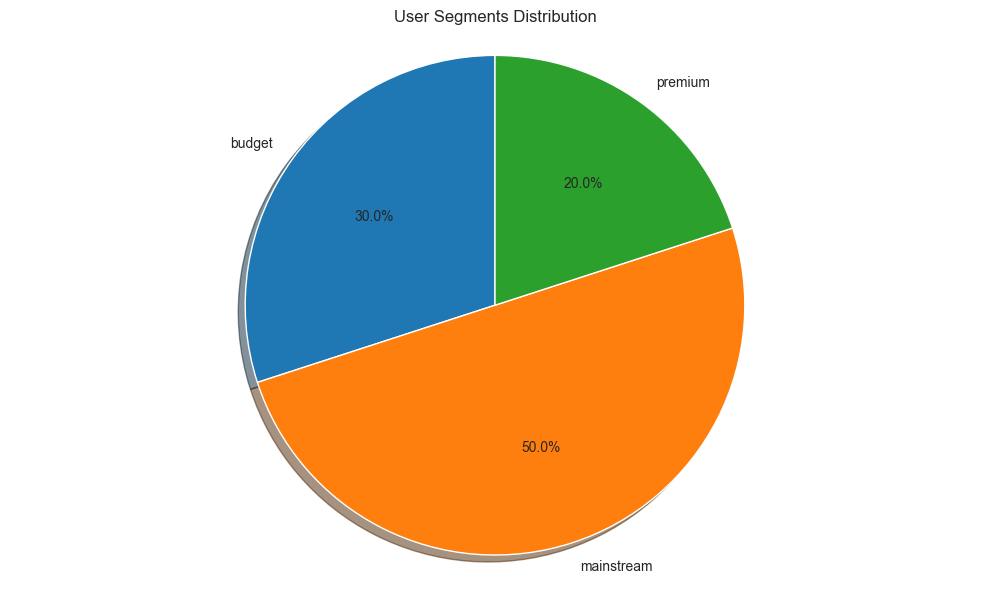

User segments visualization saved to 'user_segments_distribution.png'


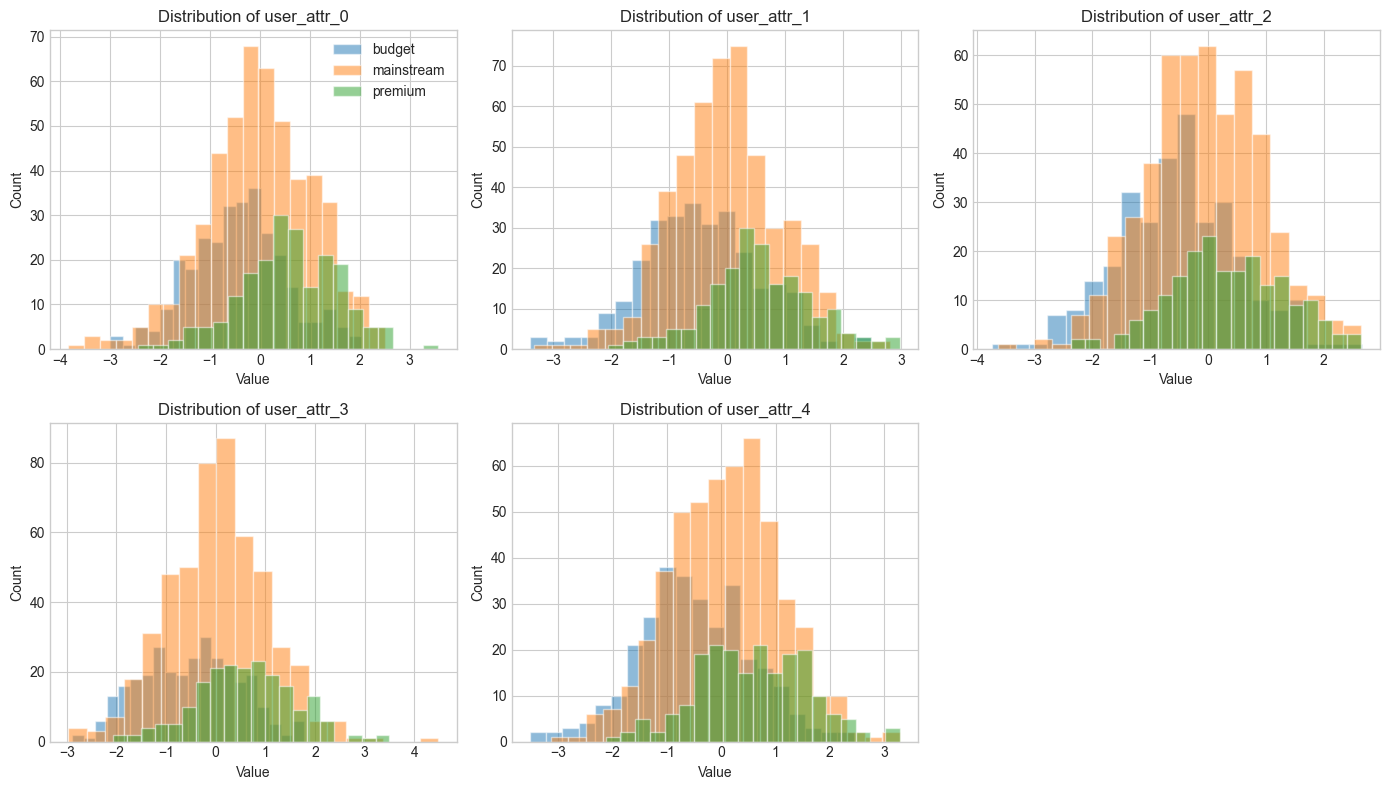

User feature distributions saved to 'user_feature_distributions.png'


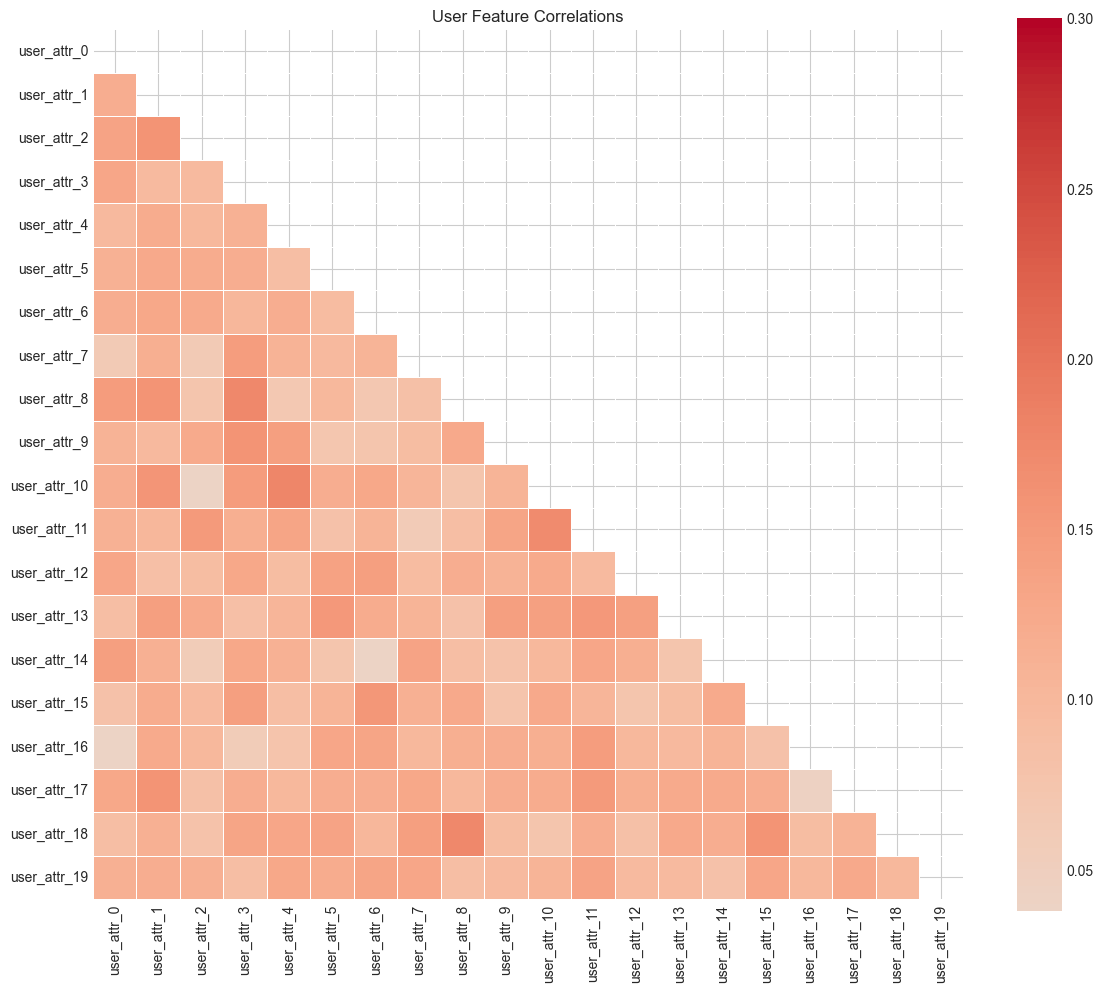

User feature correlations saved to 'user_feature_correlations.png'

=== Item Data Exploration ===
Total number of items: 200

Item Categories Distribution:
  electronics: 40 items (20.0%)
  books: 60 items (30.0%)
  clothing: 60 items (30.0%)
  home: 40 items (20.0%)


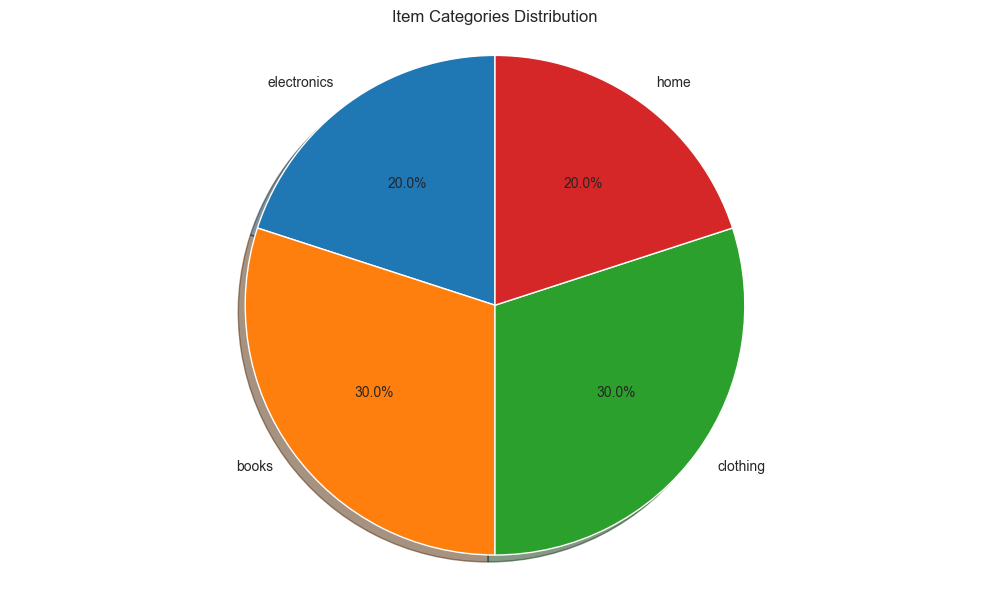

Item categories visualization saved to 'item_categories_distribution.png'


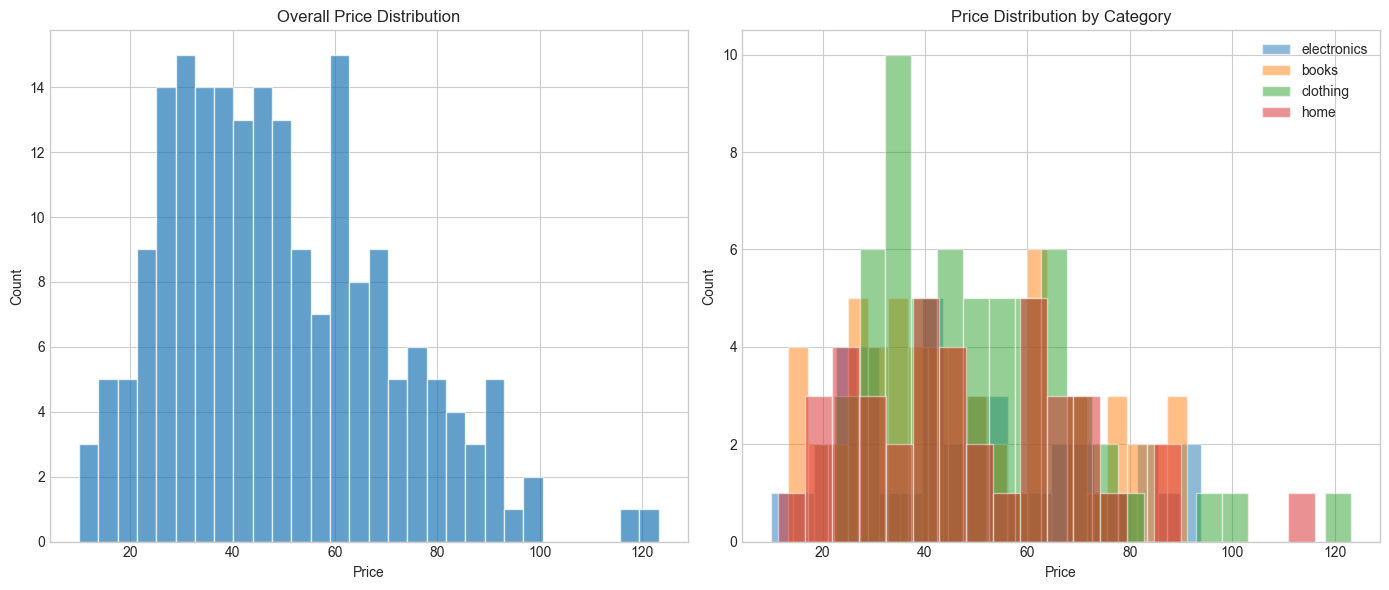

Item price distributions saved to 'item_price_distributions.png'


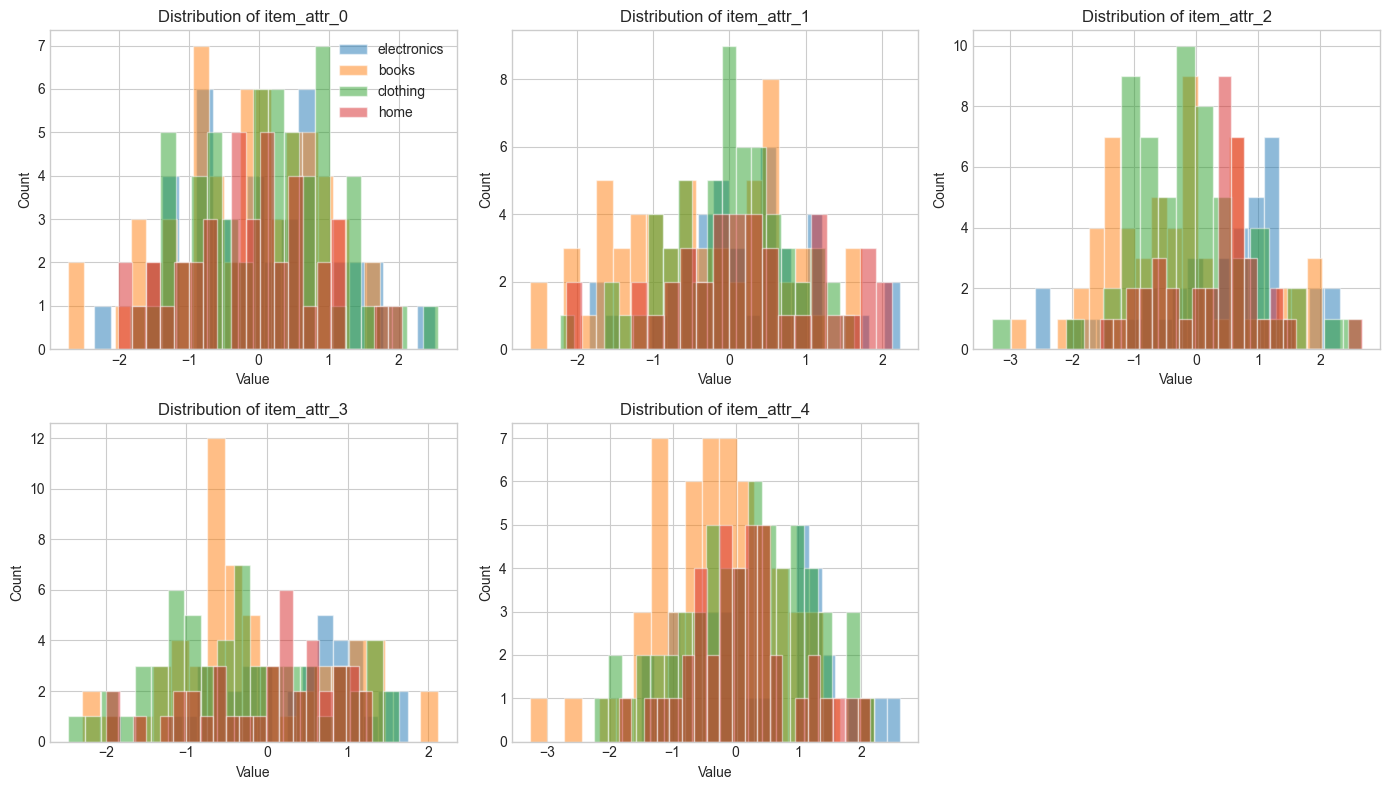

Item feature distributions saved to 'item_feature_distributions.png'

=== Interaction Data Exploration ===
Total interactions: 200
Interaction density: 0.1000%
Users with at least one interaction: 181 (18.1%)
Items with at least one interaction: 132 (66.0%)


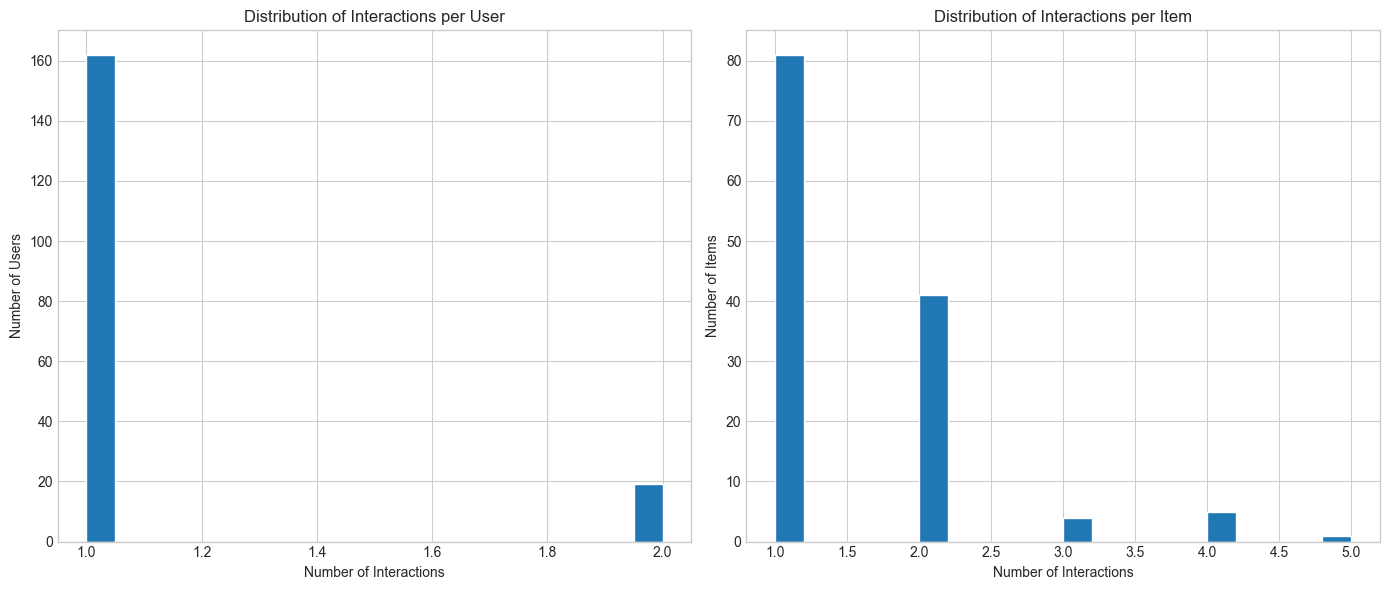

Interaction distributions saved to 'interaction_distributions.png'


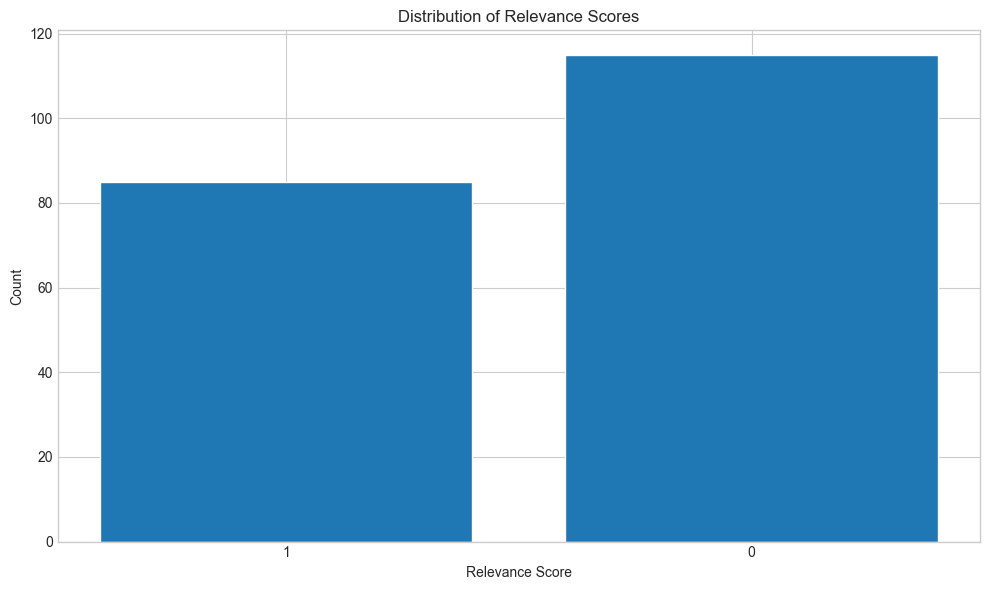

Relevance distribution saved to 'relevance_distribution.png'


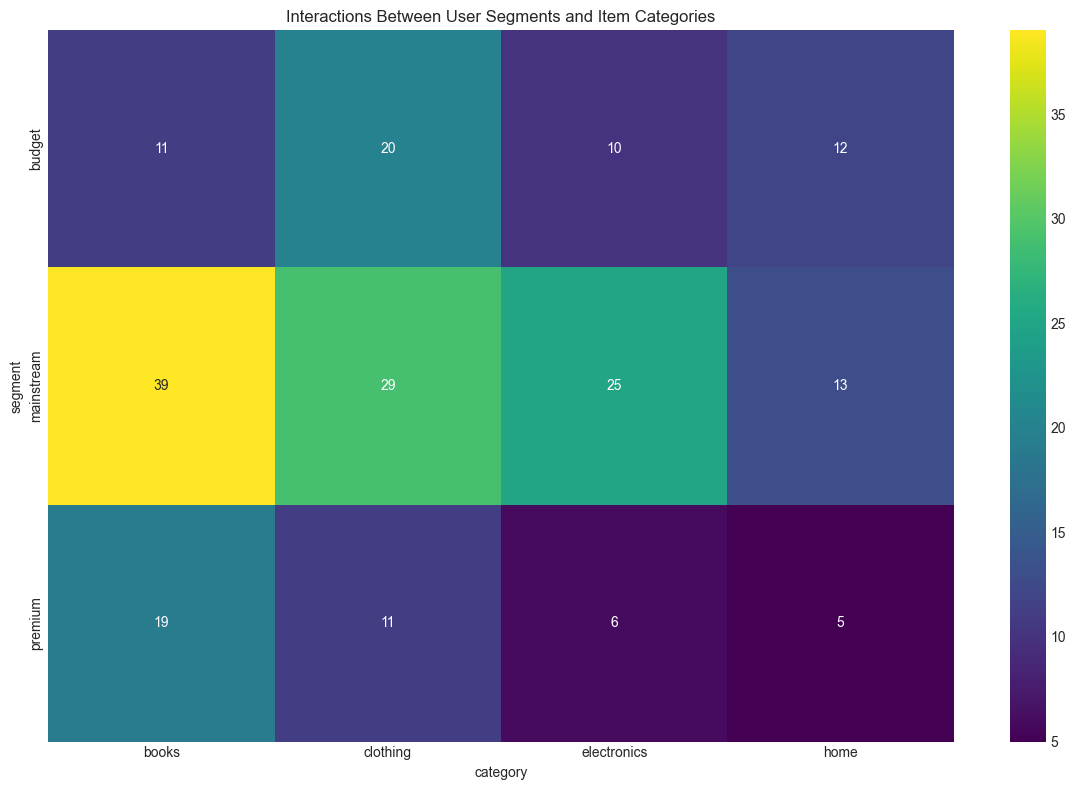

Segment-category interactions saved to 'segment_category_interactions.png'
Exploratory analysis complete.


In [32]:
# We'll create a smaller dataset for demonstration.
config = DEFAULT_CONFIG.copy()
config['data_generation']['n_users'] = 1000  # Reduced from 10,000
config['data_generation']['n_items'] = 200   # Reduced from 1,000
config['data_generation']['seed'] = 42       # Fixed seed for reproducibility

# Get train-test split parameters
train_iterations = config['simulation']['train_iterations']
test_iterations = config['simulation']['test_iterations']

print(f"Running train-test simulation with {train_iterations} training iterations and {test_iterations} testing iterations")

# Initialize data generator
data_generator = CompetitionDataGenerator(
    spark_session=spark,
    **config['data_generation']
)

# Generate user data
users_df = data_generator.generate_users()
print(f"Generated {users_df.count()} users")

# Generate item data
items_df = data_generator.generate_items()
print(f"Generated {items_df.count()} items")

# Generate initial interaction history
history_df = data_generator.generate_initial_history(
    config['data_generation']['initial_history_density']
)
print(f"Generated {history_df.count()} initial interactions")

print("\n=== Starting Exploratory Data Analysis ===")
explore_user_data(users_df)
explore_item_data(items_df)
explore_interactions(history_df, users_df, items_df)

print("Exploratory analysis complete.")

## Set up Generators and Recommenders

In [33]:
# Prepare data generators for the simulator
user_generator, item_generator = data_generator.setup_data_generators()

# Initialize the recommenders we want to compare
recommenders = [
    RandomRecommender(seed=42),
    PopularityRecommender(alpha=1.0, seed=42),
    #ContentBasedRecommender(similarity_threshold=0.0, seed=42),
    kNearestRecommender(seed=42)  # Custom template class
]
recommender_names = ["Random", "Popularity", #"ContentBased", \
                     "kNearestRecommender"]

# Fit each recommender on the initial history
for recommender in recommenders:
    recommender.fit(log=data_generator.history_df)

print("Recommenders set up and initial fit complete.")

Recommenders set up and initial fit complete.


## Train-Test Simulation and Evaluation

In [42]:
import pandas as pd

results = []

for name, recommender in zip(recommender_names, recommenders):
    print(f"\nEvaluating {name}:")
    
    # Clean up any existing simulator data directory for this recommender
    simulator_data_dir = f"simulator_train_test_data_{name}"
    if os.path.exists(simulator_data_dir):
        shutil.rmtree(simulator_data_dir)
        print(f"Removed existing simulator data directory: {simulator_data_dir}")
    
    # Initialize simulator
    simulator = CompetitionSimulator(
        user_generator=user_generator,
        item_generator=item_generator,
        data_dir=simulator_data_dir,
        log_df=data_generator.history_df,  # PySpark DataFrames don't have copy method
        conversion_noise_mean=config['simulation']['conversion_noise_mean'],
        conversion_noise_std=config['simulation']['conversion_noise_std'],
        spark_session=spark,
        seed=config['data_generation']['seed']
    )
    
    # Run simulation with train-test split
    train_metrics, test_metrics, train_revenue, test_revenue = simulator.train_test_split(
            recommender=recommender,
            train_iterations=train_iterations,
            test_iterations=test_iterations,
            user_frac=config['simulation']['user_fraction'],
            k=config['simulation']['k'],
            filter_seen_items=config['simulation']['filter_seen_items'],
            retrain=config['simulation']['retrain']
        )
    
    # Calculate average metrics
    train_avg_metrics = {}
    for metric_name in train_metrics[0].keys():
        values = [m[metric_name] for m in train_metrics]
        train_avg_metrics[f"train_{metric_name}"] = np.mean(values)
    
    test_avg_metrics = {}
    for metric_name in test_metrics[0].keys():
        values = [m[metric_name] for m in test_metrics]
        test_avg_metrics[f"test_{metric_name}"] = np.mean(values)
    
    # Store results
    results.append({
        "name": name,
        "train_total_revenue": sum(train_revenue),
        "test_total_revenue": sum(test_revenue),
        "train_avg_revenue": np.mean(train_revenue),
        "test_avg_revenue": np.mean(test_revenue),
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "train_revenue": train_revenue,
        "test_revenue": test_revenue,
        **train_avg_metrics,
        **test_avg_metrics
    })
    
    # Print summary for this recommender
    print(f"  Training Phase - Total Revenue: {sum(train_revenue):.2f}")
    print(f"  Testing Phase - Total Revenue: {sum(test_revenue):.2f}")
    performance_change = ((sum(test_revenue) / len(test_revenue)) / (sum(train_revenue) / len(train_revenue)) - 1) * 100
    print(f"  Performance Change: {performance_change:.2f}%")

print("\n=== Simulation and evaluation complete for all recommenders. ===")

# Convert to DataFrame for easy comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("test_total_revenue", ascending=False).reset_index(drop=True)

# Print summary table
print("\nRecommender Evaluation Results (sorted by test revenue):")
summary_cols = [
    "name", "train_total_revenue", "test_total_revenue", 
    "train_avg_revenue", "test_avg_revenue",
    "train_precision_at_k", "test_precision_at_k",
    "train_ndcg_at_k", "test_ndcg_at_k",
    "train_mrr", "test_mrr",
    "train_discounted_revenue", "test_discounted_revenue"
]
summary_cols = [col for col in summary_cols if col in results_df.columns]

if len(summary_cols) > 0:
    print(results_df[summary_cols].to_string(index=False))
else:
    print("No summary columns to display.")


Evaluating Random:
Removed existing simulator data directory: simulator_train_test_data_Random
Starting Training Phase:
Training Iteration 0: Revenue = 2594.67
Training Iteration 1: Revenue = 3177.96
Training Iteration 2: Revenue = 2810.40
Training Iteration 3: Revenue = 3202.16
Training Iteration 4: Revenue = 2376.62

Starting Testing Phase:
Testing Iteration 0: Revenue = 2629.13
Testing Iteration 1: Revenue = 3053.63
Testing Iteration 2: Revenue = 2228.21
Testing Iteration 3: Revenue = 2267.67
Testing Iteration 4: Revenue = 2652.18
  Training Phase - Total Revenue: 14161.80
  Testing Phase - Total Revenue: 12830.82
  Performance Change: -9.40%

Evaluating Popularity:
Removed existing simulator data directory: simulator_train_test_data_Popularity
Starting Training Phase:
Training Iteration 0: Revenue = 3484.24
Training Iteration 1: Revenue = 3535.51
Training Iteration 2: Revenue = 3864.39
Training Iteration 3: Revenue = 3044.96
Training Iteration 4: Revenue = 1932.82

Starting Testin

c:\Users\jackn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training Iteration 0: Revenue = 2309.66


c:\Users\jackn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training Iteration 1: Revenue = 2231.16


c:\Users\jackn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training Iteration 2: Revenue = 1911.22


c:\Users\jackn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training Iteration 3: Revenue = 1796.41


c:\Users\jackn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training Iteration 4: Revenue = 1989.34

Starting Testing Phase:


c:\Users\jackn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Testing Iteration 0: Revenue = 3183.24


c:\Users\jackn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Testing Iteration 1: Revenue = 1879.09


c:\Users\jackn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Testing Iteration 2: Revenue = 2808.78


c:\Users\jackn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Testing Iteration 3: Revenue = 2456.66


c:\Users\jackn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Testing Iteration 4: Revenue = 2350.23
  Training Phase - Total Revenue: 10237.79
  Testing Phase - Total Revenue: 12678.00
  Performance Change: 23.84%

=== Simulation and evaluation complete for all recommenders. ===

Recommender Evaluation Results (sorted by test revenue):
               name  train_total_revenue  test_total_revenue  train_avg_revenue  test_avg_revenue  train_precision_at_k  test_precision_at_k  train_ndcg_at_k  test_ndcg_at_k  train_mrr  test_mrr  train_discounted_revenue  test_discounted_revenue
             Random         14161.801800        12830.823112        2832.360360       2566.164622              0.111371             0.095635         0.602569        0.638634   0.209651  0.201890               1660.597222              1548.337058
kNearestRecommender         10237.789032        12677.999937        2047.557806       2535.599987              0.089464             0.101194         0.597056        0.635600   0.182383  0.213241               1205.591012           

## Results Visualization


=== Visualizing Recommender Performance ===


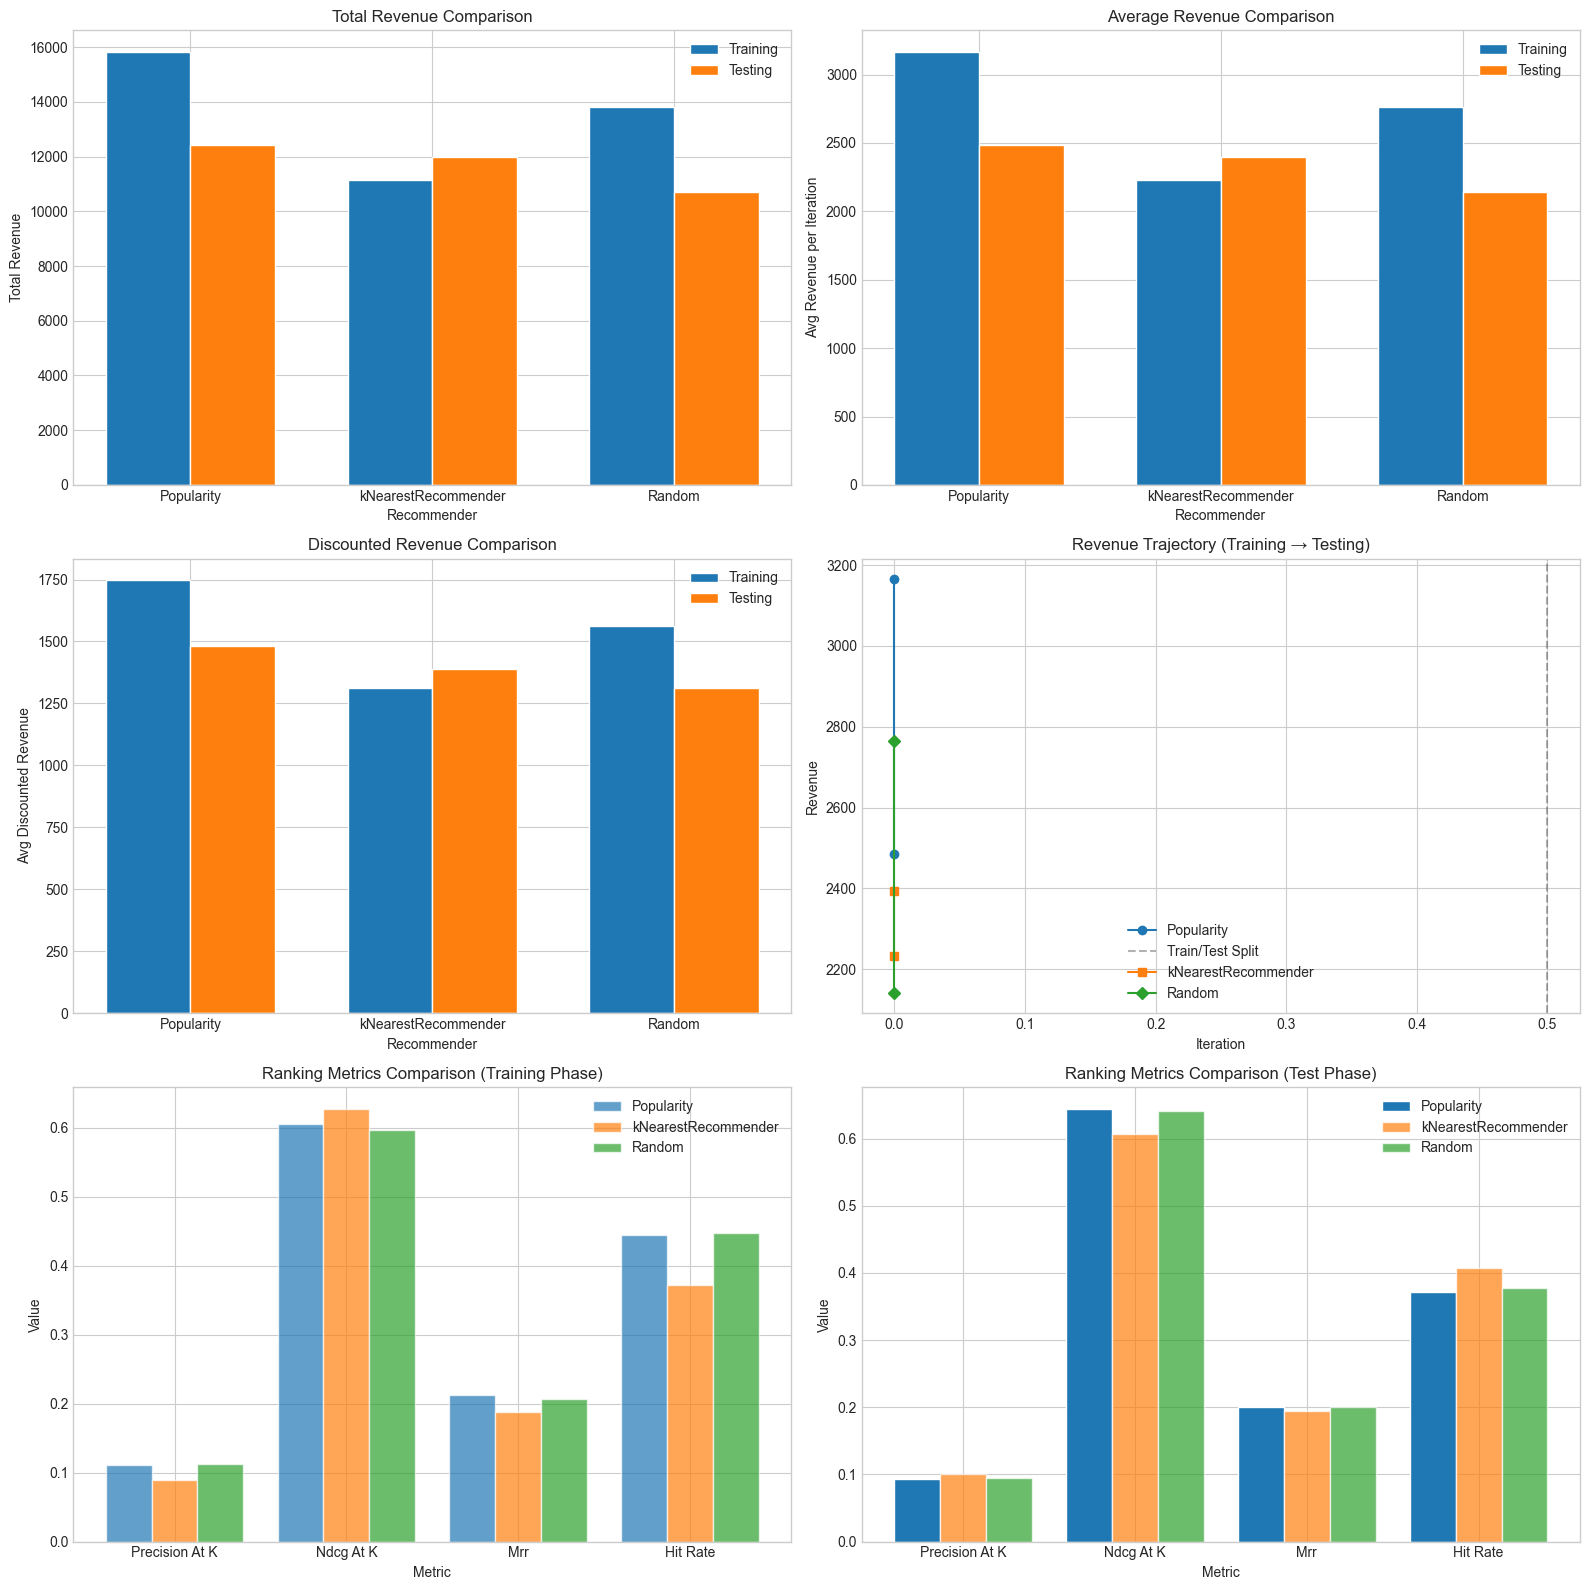


Performance visualizations saved to 'recommender_performance_comparison.png'


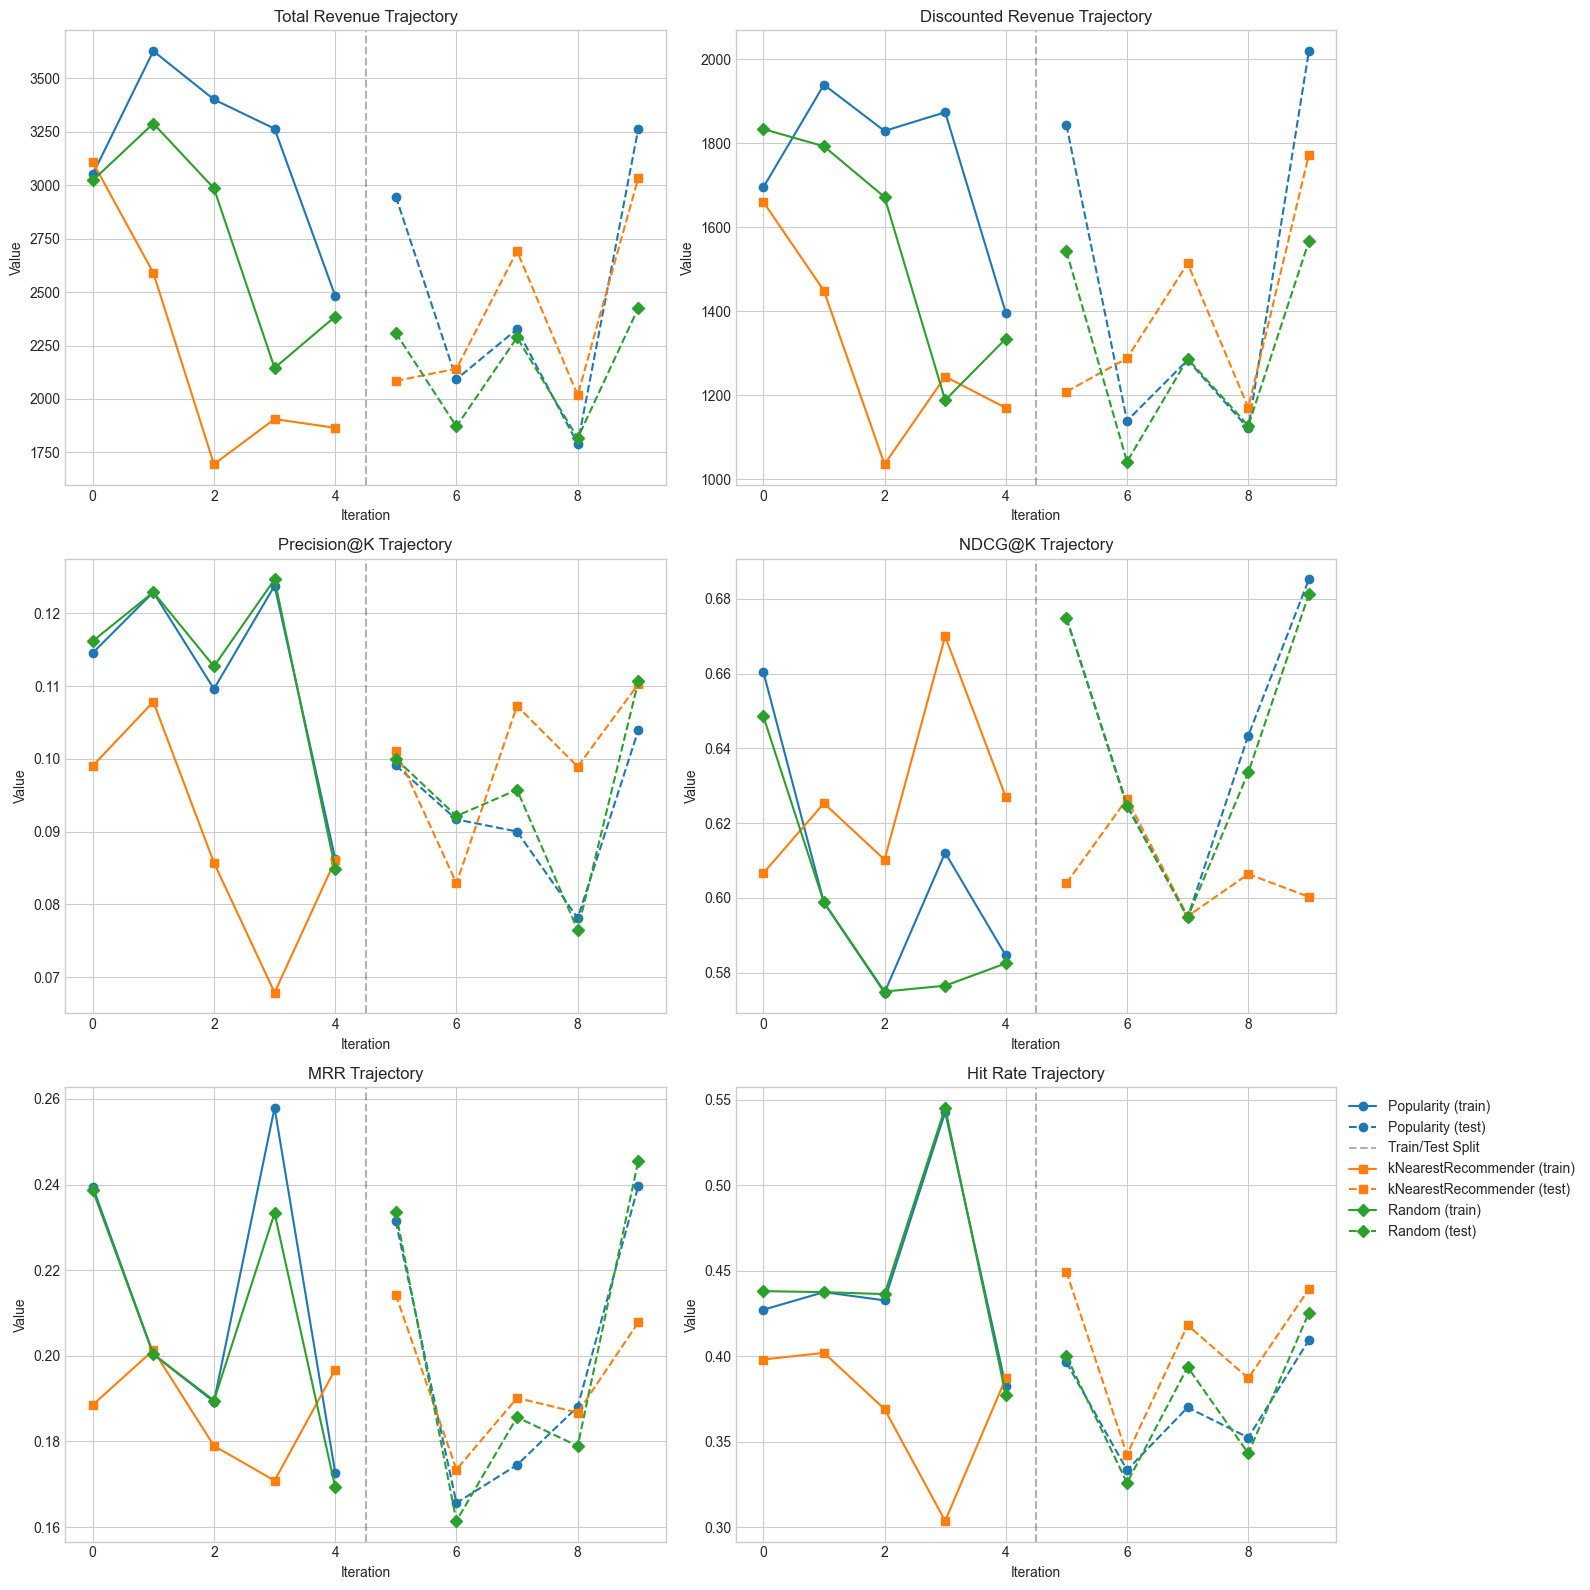

Detailed metrics visualizations saved to 'recommender_metrics_trajectories.png'


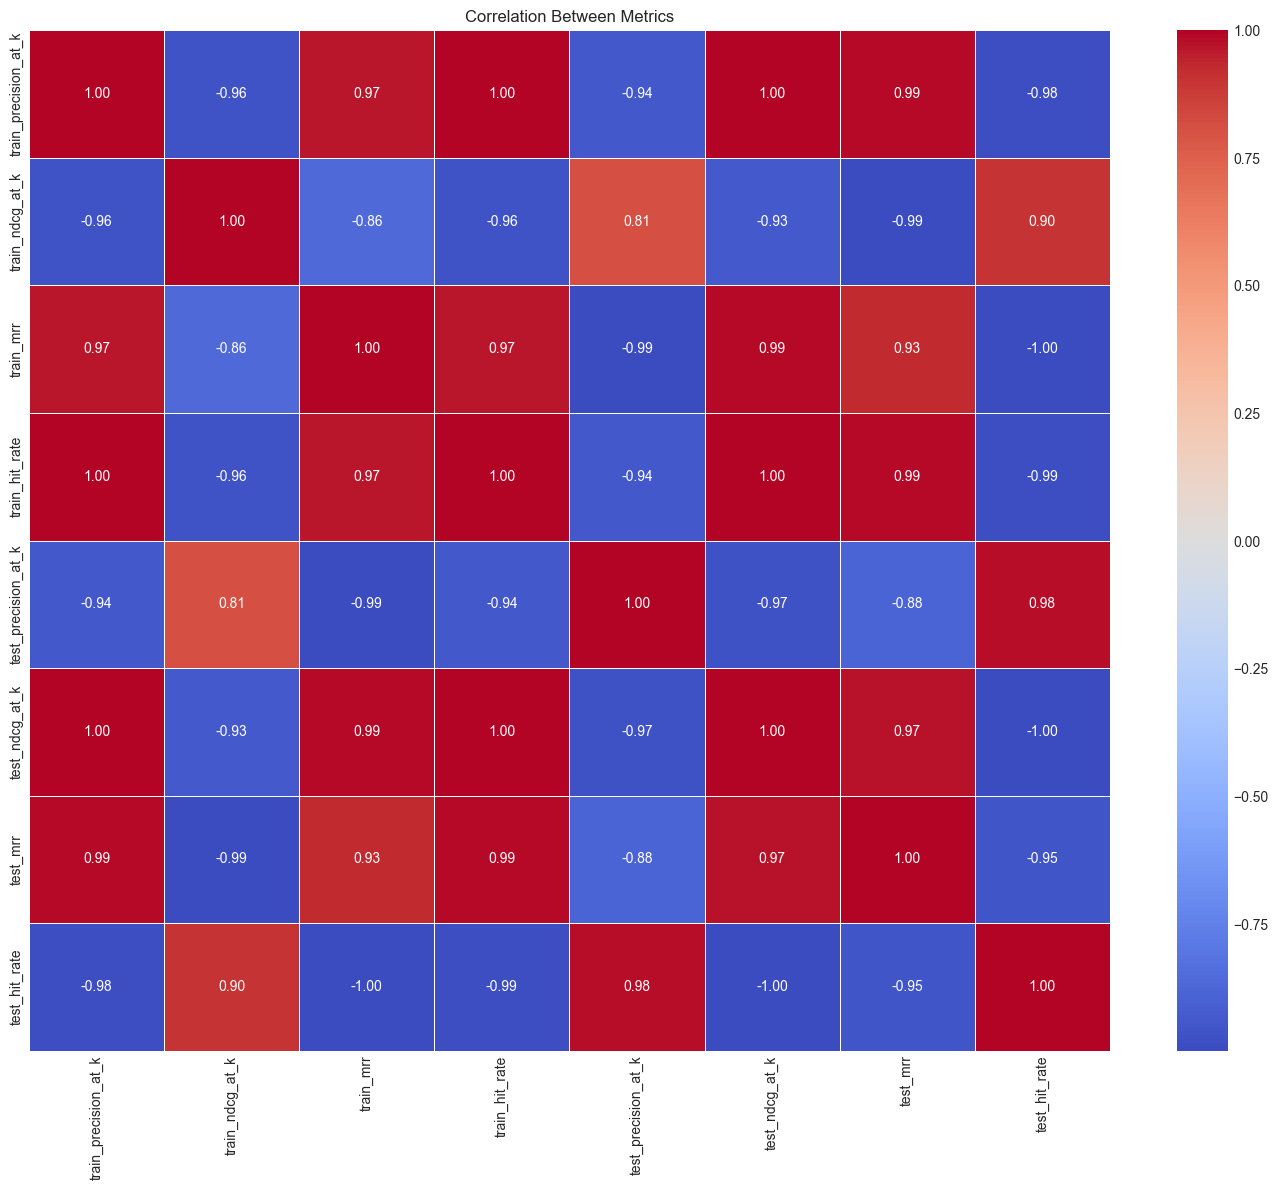

Metrics correlation heatmap saved to 'metrics_correlation_heatmap.png'

Visualization complete.


In [35]:
print("\n=== Visualizing Recommender Performance ===")
visualize_recommender_performance(results_df, recommender_names)
visualize_detailed_metrics(results_df, recommender_names)

print("\nVisualization complete.")

In [36]:
recommender = kNearestRecommender(metric='euclidean', seed=42)
recommender.fit(log=data_generator.history_df)